<a href="https://colab.research.google.com/github/Pmilivojevic/COVID_detection/blob/main/COVID_19_X_Ray_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kod ovog projektnog zadatka, glavni problem je nedovoljno primera, X-ray snimaka Covid pozitivnih osoba, koji bi se koristili za treniranje neuronske mreze od nule. U ovom, kao i u slicnim slucajevima, kada je trening skup nedovoljno veliki, koriste se Transfer-learning i Fine-tuning tehnike za treniranje modela koji bi najoptimalnije izvrsavao trazeni zadatak.

Strategija koju sam realizovao, sastoji se u tri koraka:
  - Transfer learning
  - Augmentacija skupa za treniranje
  - Fine-uning

Transfer learning korak se odvija na sledeci nacin. Koristio sam open source modele trenirane na, takodje open source skupu slika, ImageNet. Kako je Keras, machine learning biblioteka koju koristim u ovom projektu, na ovom linku se nalazi spisak modela https://keras.io/api/applications/. Ja sam odabrao sedam modela koji, na ImageNet skupu slika daju, daju najvisi Accuracy score, u nadi da ce jedan od njih dati najoptimalnije rezultate.

Ovaj korak se sastoji u tome da se sa vrha mreze odstrane potpuno povezani slojevi, koji su istrenirani za 1000 ImageNet klasa. Sada je mreza potpuno konvoluciona i koja na izlazu daje feature vektor. Na ovakvu mrezu, mi sada dodajemo dva nova potpuno povezana sloja, jedan skriveni i jedan na izlazu mreze, koji ima dva neurona, jedan za pozitivne, drugi za negativne Covid snimke. Feature vektor, koji daje potpuno konvoluciona mreza, predstavlja ulaz za deo mreze koji predstavljaju potpuno povezani slojevi. U ovom koraku zamrzavamo potpuno konvolucione slojeve za treniranje i treniramo samo potpuno povezane slojeve koje smo dodali. Na ovaj nacin mreya koristi steceno znanje, na ImageNet skupu slika, i prenosi ga na nove dodate slojeve, otud i naziv ovoj tehnici Transfer learning.

Za treniranje koristi se skup X-ray snimaka koji se nalaze na GitHub repozitorijumu: https://github.com/muhammedtalo/COVID-19. Iz ovog skupa smo izdvojili 114 Covid pozitivnih i 156 Covid negativnih snimaka. Od svake od ovih grupa slika, izdvojili smo po 20 slika za testiranje. Transfer learning se vrsi sa ovako uredjenim skupom snimaka.

Nakon sto se izvrsi dotreniravanje ovih sedam odabranih modela, radi se uporedna analiza (https://colab.research.google.com/drive/1kNKGbvR4WXzLCg1yqCXVNsoY61dkT4NS#scrollTo=TpFTAmy4YB68) i bira se onaj model sa najvisim skorom za korak Fine-tuning.

U Fine-tuning koraku svi sloijevi mreze se odmrzavaju za treniranje i sada se trenira celokupna mreza, ukljucujuci i konvolucione slojeve, za problem detekcije Covid pozitivnih X-ray snimaka.

Fine-tuning treniranje se, u ovom koraku, vrsi nad prosirenim skupom slika, koji se dobija u koraku Augmentacije skupa za treniranje.

In [ ]:
# Ucitavanje potrebnih biblioteka

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, ResNet152, ResNet50V2, ResNet152V2, InceptionV3, InceptionResNetV2, NASNetLarge
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import seaborn as sbn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
#import argparse
import cv2
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Putanje do trening snimaka
trainPath1= '/content/drive/MyDrive/Colab Notebooks/covidKonferencija/data/train/bacterialPneumonia'
trainPath2= '/content/drive/MyDrive/Colab Notebooks/covidKonferencija/data/train/viralPneumonia'
testPath1= '/content/drive/MyDrive/Colab Notebooks/covidKonferencija/data/test/bacterialPneumonia'
testPath2= '/content/drive/MyDrive/Colab Notebooks/covidKonferencija/data/test/viralPneumonia'

trainPath= '/content/drive/My Drive/Colab Notebooks/covidDetection/Train'
covid19Path= '/content/drive/My Drive/Colab Notebooks/covidDetection/Train/covid19'
normalPath= '/content/drive/My Drive/Colab Notebooks/covidDetection/Train/normal'
trainAugmentedPath= '/content/drive/My Drive/Colab Notebooks/covidDetection/TrainAugmented'
trainCovid19AugmentedPath= '/content/drive/My Drive/Colab Notebooks/covidDetection/TrainAugmented/covid19'
trainNormalAugmentedPath= '/content/drive/My Drive/Colab Notebooks/covidDetection/TrainAugmented/normal'

In [ ]:
labelsDict

{'bacterialPneumonia': array([1., 0.], dtype=float32),
 'viralPneumonia': array([0., 1.], dtype=float32)}

In [ ]:
# Parametri za augmentaciju u toku samog treniranja, cime se obezbedjuje da svaka epoha koristi naizgled drugacije snimke

aug = ImageDataGenerator(
	rotation_range= 2,
	zoom_range= 0.05,
	#width_shift_range=0.07,
	#height_shift_range=0.07,
	#shear_range=0.04,
	horizontal_flip= True,
	fill_mode= "nearest")

In [ ]:
# Ucitavanje trening seta podataka

TrainImagePaths = list(paths.list_images(trainPath1))
data = []
classes = []
nBacterial= 0

for trainImagePath in TrainImagePaths:
  if nBacterial < 1500:
    label = trainImagePath.split(os.path.sep)[-2]
    image = cv2.imread(trainImagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    classes.append(label)
    nBacterial+= 1

TrainImagePaths = list(paths.list_images(trainPath2))

for trainImagePath in TrainImagePaths:
  label = trainImagePath.split(os.path.sep)[-2]
  image = cv2.imread(trainImagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))
  data.append(image)
  classes.append(label)
# Slike se normalizuju na opseg (-1.0, 1.0)
data = np.array(data)
data= (data-127.5)/127.5
classes = np.array(classes)

lb = LabelBinarizer()
labels = lb.fit_transform(classes)
labels = to_categorical(labels)

labelsDict = dict()

for i in range(len(classes)):
  if classes[i] in labelsDict:
    pass
  else:
    labelsDict.update({classes[i]: labels[i]})

# Trening set se dodatno deli na trening set i validacioni set u odnosu 80:20 u korist trening seta
(trainX, validationX, trainY, validationY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [ ]:
dataTest = []
classesTest = []
labelsTest= np.zeros((400,1))

classTemp= ''
i = 0
#n = -1

for testImagePath in list(paths.list_images(testPath1)):
  label = testImagePath.split(os.path.sep)[-2]
  classesTest.append(label)
  labelsTest[i]= 0
  i+= 1
  image = cv2.imread(testImagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))
  dataTest.append(image)

for testImagePath in list(paths.list_images(testPath2)):
  label = testImagePath.split(os.path.sep)[-2]
  classesTest.append(label)
  labelsTest[i]= 1
  i+= 1
  image = cv2.imread(testImagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))
  dataTest.append(image)

classesTest= np.array(classesTest)
dataTest = np.array(dataTest).reshape(-1, 224, 224, 3)
dataTestNorm = (dataTest-127.5)/127.5

labelsTest = to_categorical(labelsTest)
labelsDictTest = dict()

for i in range(len(classesTest)):
  if classesTest[i] in labelsDictTest:
    pass
  else:
    labelsDictTest.update({classesTest[i]: labelsTest[i]})

In [ ]:
# Ucitavanje osnovnog modela bez vrha koji cini potpono povezani sloj

baseModel = ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Dodaje se jedan skriveni potpuno povezani sloj, nad kojim se primenjuje dropout, kako bi se smanjila sansa za overfitting-om
# Na vrh mere ze potom dodaje i izlazni sloj daje trazeni rezultat
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Konkatenacija baze modela i glave koju smo upravo kreirali
model = Model(inputs=baseModel.input, outputs=headModel)

# Zamrzavanje baze modela, konvolucionih slojeva, za treniranje
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# Ucitavanje dotreniranog modela za fine-tuning korak

model= load_model('/content/drive/My Drive/Colab Notebooks/covidDetection/covidModels/transferLearning/InceptionResNetV2.h5')

In [ ]:
# Odmrzavanje svih slojeva za treniranje u fine-tuning koraku

for layer in model.layers[450:]:
  layer.trainable = True

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [ ]:
# U oba koraka, neophodno je kompajlirati model pre pocetka treniranja

INIT_LR = 1e-4  # U transfer learning koraku koristi se learning-rate od 0.001, a u fine-tuning koraku od 0.0001
EPOCHS = 50     # U transfer learning koraku koristi se broj epoha 50, a u fine-tuning koraku 16
BS = 128         # U transfer learning koraku koristi se batch size od 64, a u fine-tuning koraku od 16
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss=[categorical_focal_loss(alpha=[[0.5, 2.0]], gamma=2)], optimizer=opt, metrics=["accuracy"])

In [ ]:
# Treniranje

H = model.fit(aug.flow(trainX, trainY, batch_size= BS), validation_data=(validationX, validationY), steps_per_epoch=len(trainX) // BS, epochs=EPOCHS)

Epoch 1/50
16/16 [==============================] - 31s 1s/step - loss: 0.1525 - accuracy: 0.4332 - val_loss: 0.1442 - val_accuracy: 0.4329
Epoch 2/50
16/16 [==============================] - 21s 1s/step - loss: 0.1492 - accuracy: 0.4258 - val_loss: 0.1439 - val_accuracy: 0.4329
Epoch 3/50
16/16 [==============================] - 22s 1s/step - loss: 0.1494 - accuracy: 0.4076 - val_loss: 0.1435 - val_accuracy: 0.4329
Epoch 4/50
16/16 [==============================] - 21s 1s/step - loss: 0.1506 - accuracy: 0.4342 - val_loss: 0.1434 - val_accuracy: 0.4329
Epoch 5/50
16/16 [==============================] - 21s 1s/step - loss: 0.1454 - accuracy: 0.4234 - val_loss: 0.1434 - val_accuracy: 0.4329
Epoch 6/50
16/16 [==============================] - 21s 1s/step - loss: 0.1462 - accuracy: 0.4415 - val_loss: 0.1435 - val_accuracy: 0.4329
Epoch 7/50
16/16 [==============================] - 21s 1s/step - loss: 0.1468 - accuracy: 0.4331 - val_loss: 0.1434 - val_accuracy: 0.4329
Epoch 8/50
16/16 [==

In [ ]:
# Cuvanje modela

model_save_path= '/content/drive/My Drive/Colab Notebooks/covidDetection/covidModels/fineTuning/InceptionResNetV2_fineTuned.h5'
model.save(model_save_path)

NameError: ignored

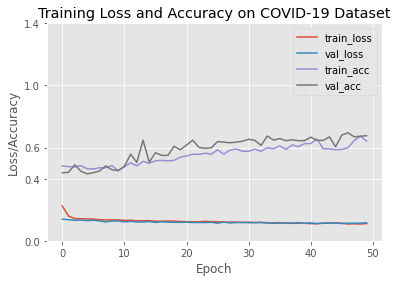

In [ ]:
# Plot loss funkcije i tacnosti kroz epohe treniranja

N = EPOCHS
plt.style.use("ggplot")
fig= plt.figure()
ax= plt.subplot2grid((1,1), (0,0))
ax.plot(np.arange(0, N), H.history["loss"], label="train_loss")
ax.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
ax.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
ax.set_yticks([0, 0.4, 0.6, 1.0, 1.4])
#plt.savefig('/content/drive/My Drive/Colab Notebooks/covidDetection/trainingPlots/InceptionResNetV2_fineTuned.png', dpi= 500)

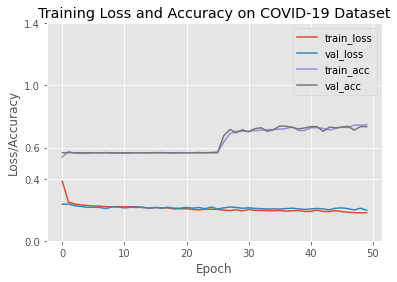

In [ ]:
# Plot loss funkcije i tacnosti kroz epohe treniranja

N = EPOCHS
plt.style.use("ggplot")
fig= plt.figure()
ax= plt.subplot2grid((1,1), (0,0))
ax.plot(np.arange(0, N), H.history["loss"], label="train_loss")
ax.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
ax.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
ax.set_yticks([0, 0.4, 0.6, 1.0, 1.4])
#plt.savefig('/content/drive/My Drive/Colab Notebooks/covidDetection/trainingPlots/InceptionResNetV2_fineTuned.png', dpi= 500)

In [ ]:
pred= model.predict(dataTestNorm)

Text(0.5, 1.0, 'ResNet152')

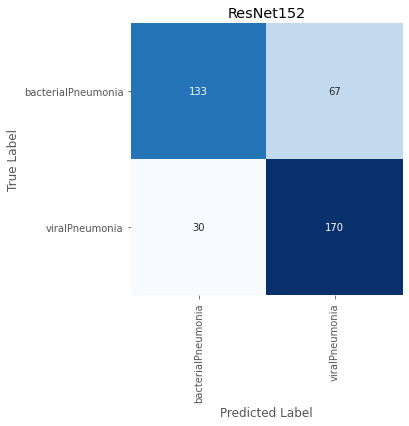

In [ ]:
name= 'ResNet152'
#model= load_model('/content/drive/MyDrive/Colab Notebooks/covidKonferencija/models_fe/' + name + '.h5')
#pred= model.predict(dataTest)
predIdxs= np.argmax(pred, axis=1)
lIdxs= np.argmax(labelsTest, axis=1)

cm= confusion_matrix(lIdxs, predIdxs)
fig= plt.figure(figsize= (5,5))
ax1= sbn.heatmap(cm, square= True, annot= True, fmt= 'd', cbar= False, cmap= 'Blues')
ax1.set_xticklabels(labelsDictTest, rotation= 90)
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.set_yticklabels(labelsDictTest, rotation= 00)
ax1.set_title(name)

Text(0.5, 1.0, 'ResNet152')

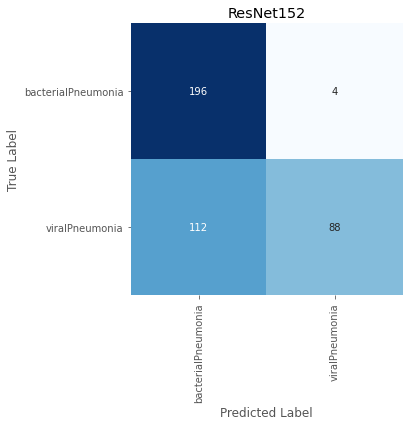

In [ ]:
name= 'ResNet152'
#model= load_model('/content/drive/MyDrive/Colab Notebooks/covidKonferencija/models_fe/' + name + '.h5')
#pred= model.predict(dataTest)
predIdxs= np.argmax(pred, axis=1)
lIdxs= np.argmax(labelsTest, axis=1)

cm= confusion_matrix(lIdxs, predIdxs)
fig= plt.figure(figsize= (5,5))
ax1= sbn.heatmap(cm, square= True, annot= True, fmt= 'd', cbar= False, cmap= 'Blues')
ax1.set_xticklabels(labelsDictTest, rotation= 90)
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.set_yticklabels(labelsDictTest, rotation= 00)
ax1.set_title(name)